Dr. Marques' Introduction to Data Science guest talk - Fall 2020

Step 6

**Improvements in this step**

1. Explain what the code blocks are doing (the last missing ones, in the analysis section)
1. Describe limitations of the conclusion

-----------------

# Purpose

This notebook investigates the question "Is there gender discrimination in the salaries of an organization?"

To answer the question, it assumes that people in the same position, performing at the same level, should have comparable salaries, independent of their gender.

# Exploratory data analysis

This section reviews the data available for the analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
salaries = pd.read_csv("data/salaries.csv")

## What data do we have?

Columns in the dataset:

In [3]:
salaries.columns

Index(['earn', 'height', 'sex', 'ed', 'age', 'race'], dtype='object')

The dataset has these pieces of information for each employee:

1. `earn`: the annual salary
1. `height`: the height in inches
1. `sex`: the gender
1. `ed`: number of years of education
1. `age`: age in years
1. `race`: the race

## Can we trust the data?

### Are there empty values?

In [4]:
print(salaries.isnull().sum())

earn      0
height    0
sex       0
ed        0
age       0
race      0
dtype: int64


All values are present

### Do the columns have the correct data type?

In [5]:
print(salaries.dtypes)

earn      float64
height    float64
sex        object
ed          int64
age         int64
race       object
dtype: object


The columns have the correct data type.

### Do the numeric values make sense?

In [6]:
salaries.describe()

,earn,height,ed,age
count,1192.000000,1192.000000,1192.000000,1192.000000
mean,23154.773490,66.915154,13.504195,41.378356
std,19472.296925,3.853968,2.420175,15.867428
min,200.000000,57.503219,3.000000,18.000000
25%,10000.000000,64.009746,12.000000,29.000000
50%,20000.000000,66.451265,13.000000,38.000000
75%,30000.000000,69.848100,16.000000,51.000000
max,200000.000000,77.051282,18.000000,91.000000


There indications of possible issues with the numeric values:

1. `earn`: minimum salary is low, doesn't seem to be a valid annual salary.
1. `ed`:  very low years of education in some cases. They may be correct, but they may skew the analysis.
1. `age`: there are some large values for age. They may be correct, but they may skew the analysis.

We will check them in more details later.

### Do the categorical values make sense?

Does the `sex` columns make sense?

In [7]:
salaries.sex.unique()

array(['male', 'female'], dtype=object)

The values are the expected ones (we are assuming the standard binary genre identification - in real-life we should check with human resources if this task is about biological gender or if we should consider non-traditional genders, in which case the dataset may be wrong).

Does the `race` column make sense?

In [8]:
salaries.race.unique()

array(['white', 'other', 'hispanic', 'black'], dtype=object)

The values seem correct (we are missing some races, e.g. "asian" - in real life we should stop here and ask human resources if this is what they would expect to see in the data).

# Data clean-up

In the exploratory data analysis we noticed possible issues with some pieces of data:

1. `earn`: minimum salary is low, doesn't seem to be a valid annual salary.
1. `ed`: very low years of education in some cases. They may be correct, but they may skew the analysis.
1. `age`: there are some large values for age. They may be correct, but they may skew the analysis.

In this section we will check them in more details and clean up if needed.

## Salary range clean-up

The `earn` column has some low values:

In [9]:
salaries.earn.describe()

count      1192.000000
mean      23154.773490
std       19472.296925
min         200.000000
25%       10000.000000
50%       20000.000000
75%       30000.000000
max      200000.000000
Name: earn, dtype: float64

Low salaries may indicate employees that were not present for the entire period of data collection or may have some special work arrangement. Either way, they may be skewing the analysis.

We will exclude salaries below \$14,500 because this is what someone working full time (40 hours/week) would make with the current minimum wage ([$7.25 when this was written](https://www.dol.gov/general/topic/wages/minimumwage)). Note that it assumes the person works 52 weeks/year (no vacation).

In [10]:
SALARY_CUTOFF = 14_500
low_salaries = salaries.earn < SALARY_CUTOFF

# Show the affected employees to let other stakeholder (e.g. human
# resource) check if this makes sense
print(
    "{} out {:,} employees earn less than ${:,}".format(
        low_salaries.sum(), len(salaries), SALARY_CUTOFF
    )
)
salaries[low_salaries].earn.describe()

408 out 1,192 employees earn less than $14,500


count      408.000000
mean      7637.899510
std       3898.172377
min        200.000000
25%       4479.000000
50%       8000.000000
75%      11000.000000
max      14000.000000
Name: earn, dtype: float64

## Age clean-up

The `age` column has some high values:

In [11]:
salaries.age.describe()

count    1192.000000
mean       41.378356
std        15.867428
min        18.000000
25%        29.000000
50%        38.000000
75%        51.000000
max        91.000000
Name: age, dtype: float64

We will exclude ages over 66 years because [this is the full retirement age](https://www.ssa.gov/benefits/retirement/learn.html). The assumption behind this cutoff value is that employees working past the full retirment retirement age are working under different conditions than younger employees, possibly fewer hours or highly compensated, critical employees. Either way, they would skew the analysis if left in the dataset.

In [12]:
# Follow the same pattern <something>_CUTOFF
AGE_CUTOFF = 66
older_ages = salaries.age >= AGE_CUTOFF

print(
    "{} out {:,} employees are {} or older".format(
        older_ages.sum(), len(salaries), AGE_CUTOFF
    )
)
salaries[older_ages].age.describe()

120 out 1,192 employees are 66 or older


count    120.000000
mean      73.850000
std        6.237121
min       66.000000
25%       69.000000
50%       73.000000
75%       78.000000
max       91.000000
Name: age, dtype: float64

## Education level clean up

The `ed` column has some low values:

In [13]:
salaries.ed.describe()

count    1192.000000
mean       13.504195
std         2.420175
min         3.000000
25%        12.000000
50%        13.000000
75%        16.000000
max        18.000000
Name: ed, dtype: float64

We will exclude education levels below 12 years because [this is the number of years to finish high-school](https://en.wikipedia.org/wiki/Education_in_the_United_States). The assumption behind this cutoff value is that employees working before they complete high school are part-time employees, working different numbers of hours, possibly in different shifts. That variance would also skew the analysis if left in the dataset.

In [14]:
ED_CUTOFF = 12
low_ed_years = salaries.ed < ED_CUTOFF
# It's tempting to call the variable `less_than_hs`, but if we change
# the education cutoff, the variable name will no longer make sense

print(
    "{} out {:,} employees have less than {} years of education".format(
        low_ed_years.sum(), len(salaries), ED_CUTOFF
    )
)
salaries[~low_ed_years].ed.describe()

107 out 1,192 employees have less than 12 years of education


count    1085.000000
mean       13.936406
std         2.005668
min        12.000000
25%        12.000000
50%        14.000000
75%        16.000000
max        18.000000
Name: ed, dtype: float64

## Cleaned-up data

Create a cleaned-up dataset by combining the steps above. Leave the original dataset untouched, in case we need to refer to the original data later.

In [15]:
salaries_clean = salaries[~low_salaries & ~older_ages & ~low_ed_years]

Show what we have left.

In [16]:
salaries_clean.describe()

,earn,height,ed,age
count,683.000000,683.000000,683.000000,683.000000
mean,31867.506589,67.480991,14.342606,38.366032
std,20239.320668,3.846295,2.091678,10.641071
min,14500.000000,57.503219,12.000000,18.000000
25%,20000.000000,64.326516,12.000000,30.000000
50%,26000.000000,67.242771,14.000000,37.000000
75%,35000.000000,70.490709,16.000000,45.000000
max,200000.000000,77.051282,18.000000,65.000000


## Unused data

Although there are indications that taller people make more money, the difference is small and applies to both men and women, with a slightly more pronounced effect for men ([source 1](https://en.wikipedia.org/wiki/Height_discrimination), [source 2](https://www.theatlantic.com/business/archive/2015/05/the-financial-perks-of-being-tall/393518/)).

Because of the small effect and the fact that it applies to both men and women, we will remove the height column to reduce noise in the remainder of the analysis.

In [17]:
salaries_clean = salaries_clean.drop("height", axis="columns")
salaries_clean.columns

Index(['earn', 'sex', 'ed', 'age', 'race'], dtype='object')

# Gender distribution in the dataset

Now that the dataset is cleaned up, we need to check if both genders are similarly represented. A gender-skewed dataset is still useful for the analysis, but makes it more difficult.

In [18]:
female = salaries_clean.sex == "female"
print(
    "The dataset has {} female and {} male samples".format(
        len(salaries_clean[female]), len(salaries_clean[~female])
    )
)

The dataset has 342 female and 341 male samples


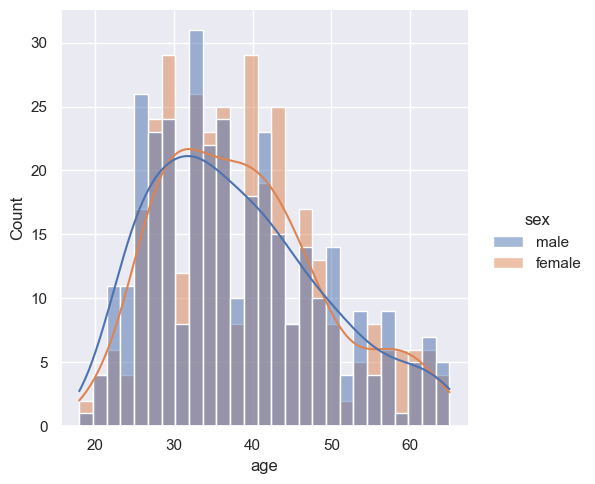

In [19]:
sns.displot(salaries_clean, x="age", hue="sex", bins="sqrt", kde=True);

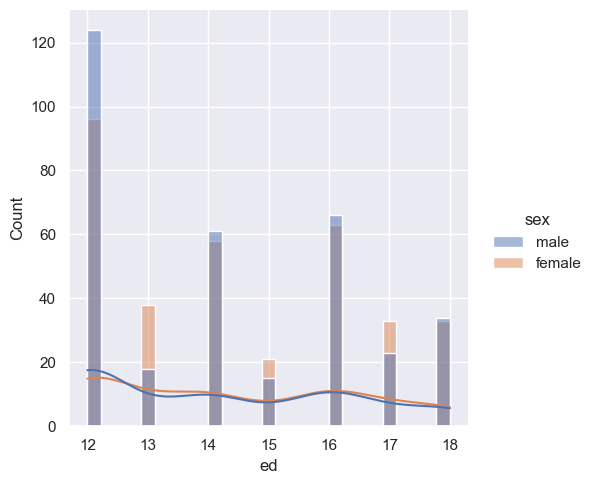

In [20]:
sns.displot(salaries_clean, x="ed", hue="sex", bins="sqrt", kde=True);

We can observe in the distributions that:

* The number of females and males in the cleaned-up dataset is about the same.
* There are variations in the age distribution, but not a large one.
* There are few instances for the younger and older age groups. This may or may not be a problem. We will check that later.
* The education distribution is about the same, with a few exceptions.

# Analysis

**REWORK NOTE**: changes start here. We will add more explanations to the graphs because we cannot assume that everyone knows how to read them, or how we are interpreting the graphs. Explaining what we are interpreting the graphs lets other validate (or challenge) the assumptions we are making.

## Using proxy data

**REWORK NOTE**: warn the reader about important limitations and assumptions we are making in the analysis.

To answer the question we would need two pieces of information not present in the dataset: position and performance evaluation of each worker.

Because we don't have those pieces of data, we will switch to another measurement: "experience". However, even for this new measurement we don't have perfect data. We will use age and education as proxies for experience (i.e. workers with the same age and education level _should_ have the same level of experience).

## Overview of the relationships among features

We will start with an overview of the relationships among the features (columns), split by sex.

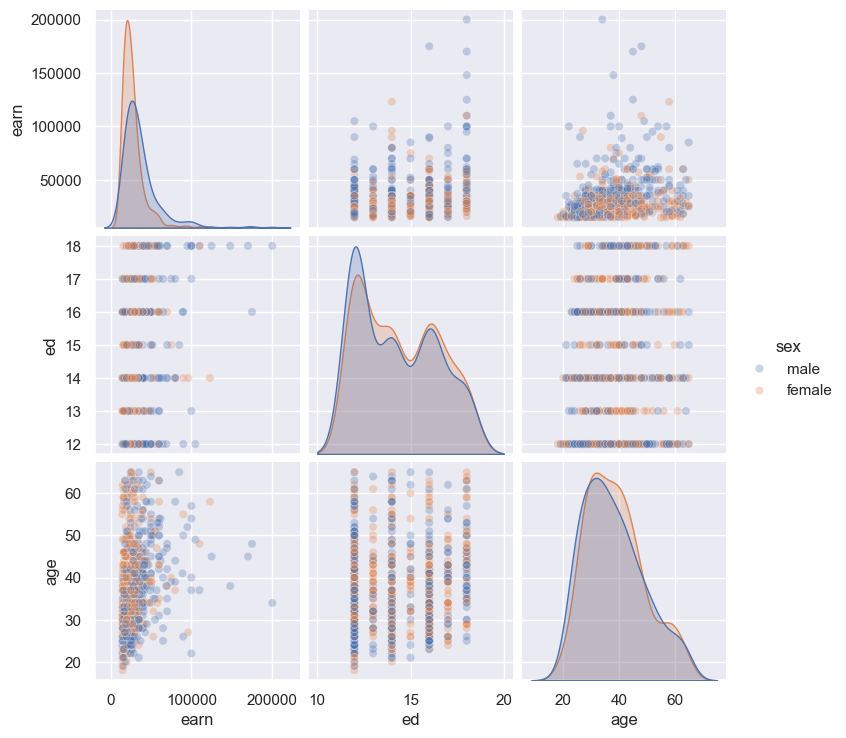

In [21]:
sns.pairplot(salaries_clean, hue="sex", plot_kws=dict(alpha=0.3));

**REWORK NOTE**: added the obserations from the pairplot.

From the pairplots we can spot a few pieces of information. The text below refers to graphs by (row, column), for example (earn, ed) is the graph in the first row (earn), third column (ed).

1. (earn, earn): the distribution shows that females earn less than males in general.
1. (earn, ed): this scatter plot indicates that for the same education level, males earn more.
1. (earn, age): this scatter plot indicates that for the same age, males earn more.
1. (ed, ed): the distribution shows that females and males have about the same level of education, as we noticed in the section above.
1. (age, age): the distribution shows that males and females have about the same age range, also as we noticed in the previous section.

Because the education and the age distributions (our proxy features) are the same for females and males, but the female salaries are lower, we have an initial indication that there is gender discrimination.

Before we delve into education and age, we need to get another item out of the way: is race a possible explanatory feature? pairplot() plots only numerical values. Because race is categorical, we have to explore it by other means.

In [22]:
salaries_clean.groupby(["sex", "race"]).size().unstack()

race,black,hispanic,other,white
sex,,,,
female,36,17,8,281
male,25,19,7,290


The distribution of races across the genders matches the overall distributions of genders. It is, therefore, reasonable to exclude race as an explanatory factor for now

## Analyzing experience through age and education

**REWORK NOTE**: section title (above) was changed to give a hint of how we will analyze the data.

To help analyze how age affects salary, we will bin the data.

We will use 22 as our first bin because this is usually the [age of graduation](https://nonpartisaneducation.org/Review/Resources/Int__lHigherEd_AppendixA.pdf). After that, we will bin every five years for the first years, to account for rapid promotions and rises that happen in the start of a career, then bin every ten years for later stages in the career, where promotions are rarer.

In [23]:
min_age = salaries_clean["age"].min()
max_age = salaries_clean["age"].max()
salaries_clean["agegroup"] = pd.cut(
    x=salaries_clean["age"], bins=[min_age - 1, 21, 26, 31, 41, 51, 61, max_age]
)

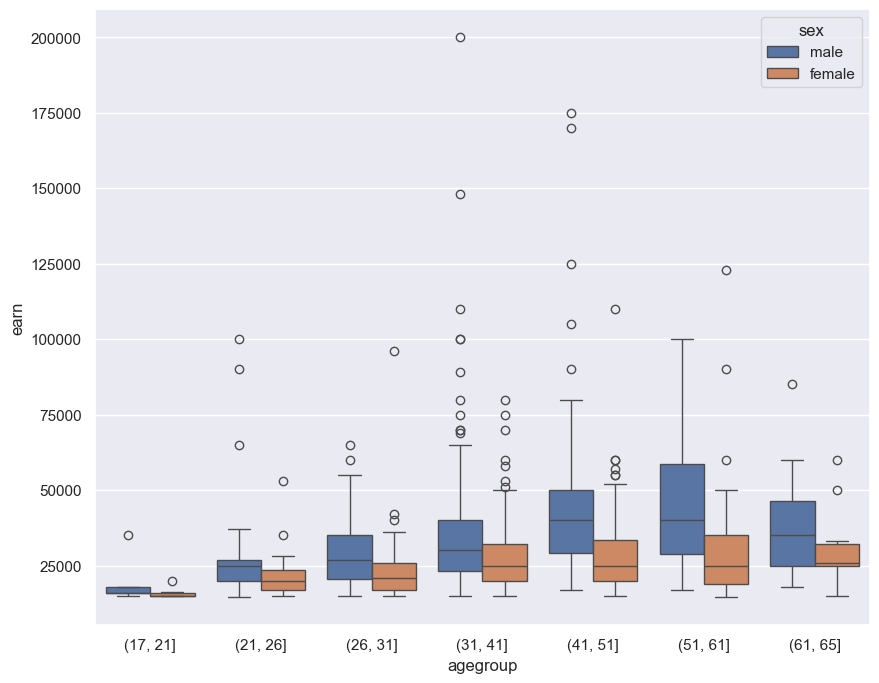

In [24]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=salaries_clean, x="agegroup", y="earn", hue="sex");

This plot shows that females earn less on average. More importantly, females earn less in all quartiles and have fewer outliers in the fourth quartile (the higher end of salaries).

## Analyzing education level

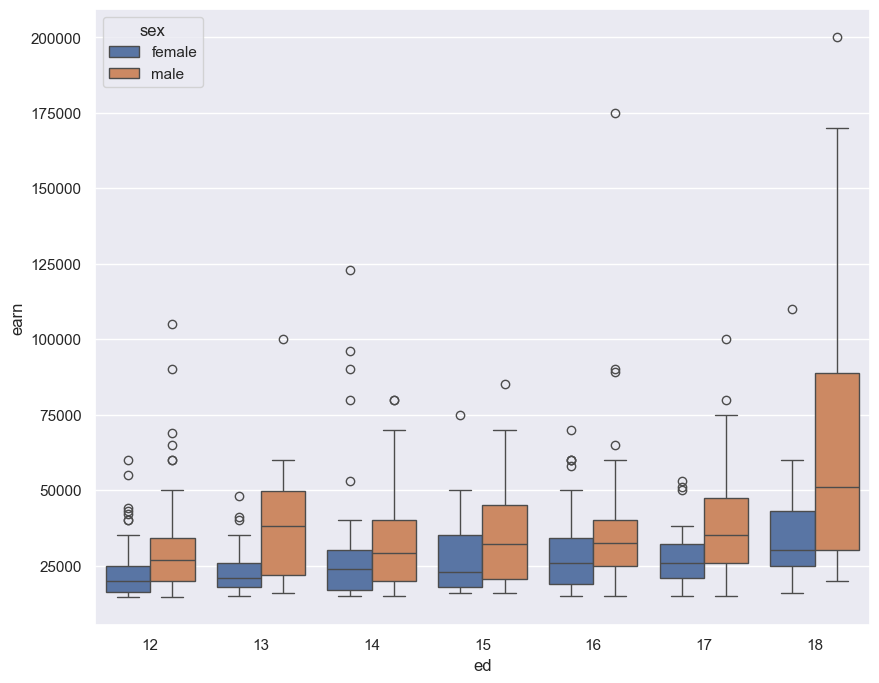

In [25]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=salaries_clean, x="ed", y="earn", hue="sex");

This plot also shows that females earn less than males on average, and again the quartiles are lower for females.

# Conclusions

**REWORK NOTE**: the conclusion explains the limitations of the data again and how we dealt with them, in case someone skips all the way down here. We also added recommended steps.

We should ideally use the position and performance to investigate possible salary discrimination. In the absence of these two pieces of information, we used "experience" instead.

However, "experience" is also not available in the dataset. We used age and education as proxies for "experience", under the assumption that people of the same age and education have the same level of experience.

With that in mind, we collected enough evidence to point to potential gender discrimination in salaries at this company:

- For the same age level, females make less on average and in general (all quartiles).
- For the same education level, females again make less on average and in general.

For the resons explained about, the data we have is not enough to be conclusive. However, it is enough to make these recommendations:

- Collect job descriptions and performance evaluation to perform a more accurate analysis. 
- Until that is done, department heads can also review the salaries of males and females doing the same job in those departments and adjust them accordingly."